In [17]:
import pandas as pd
import os
import time

# df = pd.read_csv(f"crypto_data/{csv_files[0]}", names = ['Time', 'Low', 'High', 'Open', 'Close', 'Volume'])
# print(df.head())

In [5]:
# Rading all the data files 
csv_files = []
path = "./crypto_data/"
for file in os.listdir(path):
    csv_files.append(file.split(".")[0])

main_df = pd.DataFrame()
# # Combining all the Crypto data in a single dataframe
for crypto in csv_files:
    print(crypto)
    data = f"./crypto_data/{crypto}.csv"
    df = pd.read_csv(data, names=['Time', 'Low', 'High', 'Open', 'Close', 'Volume'])
    
    df.rename(columns={"Close": f"{crypto}_Close", "Volume": f"{crypto}_Volume"}, inplace=True)
    df.set_index("Time", inplace=True)
    df = df[[f"{crypto}_Close",f"{crypto}_Volume"]]
    
    if len(main_df)==0:
        main_df = df
    else:
        main_df = main_df.join(df)
main_df.fillna(method="ffill", inplace = True)
main_df.dropna(inplace = True)
print(main_df.head())
    

ETH-USD
BCH-USD
LTC-USD
BTC-USD
            ETH-USD_Close  ETH-USD_Volume  BCH-USD_Close  BCH-USD_Volume  LTC-USD_Close  LTC-USD_Volume  BTC-USD_Close  BTC-USD_Volume
Time                                                                                                                                  
1528968720      486.01001       26.019083     870.859985       26.856577      96.660004      314.387024    6487.379883        7.706374
1528968780      486.00000        8.449400     870.099976        1.124300      96.570000       77.129799    6479.410156        3.088252
1528968840      485.75000       26.994646     870.789978        1.749862      96.500000        7.216067    6479.410156        1.404100
1528968900      486.00000       77.355759     870.000000        1.680500      96.389999      524.539978    6479.979980        0.753000
1528968960      486.00000        7.503300     869.989990        1.669014      96.519997       16.991997    6480.000000        1.490900


In [18]:
#Specifying the parameters for the NN
SEQ_LEN = 60
FUTURE_PERIOD_PREDICT = 3
RATIO_TO_PREDICT = "ETH-USD"
EPOCHS = 10
BATCH_SIZE = 64
NAME = f'{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}'

def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [7]:
main_df['Future'] = main_df[f"{RATIO_TO_PREDICT}_Close"].shift(-FUTUTE_PERIOD_PREDICT)
main_df['Target'] = list(map(classify, main_df[f"{RATIO_TO_PREDICT}_Close"], main_df['Future']))
print(main_df.head())

            ETH-USD_Close  ETH-USD_Volume  BCH-USD_Close  BCH-USD_Volume  LTC-USD_Close  LTC-USD_Volume  BTC-USD_Close  BTC-USD_Volume     Future  Target
Time                                                                                                                                                     
1528968720      486.01001       26.019083     870.859985       26.856577      96.660004      314.387024    6487.379883        7.706374  486.00000       0
1528968780      486.00000        8.449400     870.099976        1.124300      96.570000       77.129799    6479.410156        3.088252  486.00000       0
1528968840      485.75000       26.994646     870.789978        1.749862      96.500000        7.216067    6479.410156        1.404100  485.98999       1
1528968900      486.00000       77.355759     870.000000        1.680500      96.389999      524.539978    6479.979980        0.753000  485.98999       0
1528968960      486.00000        7.503300     869.989990        1.669014    

In [8]:
## In order to make a validation set out of the current dataset we have to take a percentage 
## from that dataset as a validation data

VAL_PCT = 0.10   #10% of all the data is validation data
times = sorted(main_df.index.values)

#Getting the index values of the last VAL_PCT i.e time stamp value 
final_pct = sorted(main_df.index.values)[-int(VAL_PCT*len(times))] 

validation_main_df = main_df[(main_df.index >= final_pct)] #Taking all records which have a time stamp more than the VAL_PCT timestamp
main_df = main_df[(main_df.index < final_pct)] # Rest are under training data


In [9]:
from sklearn import preprocessing #To notmalize and scale the data
import random
from collections import deque
import numpy as np

def preprocess_df(df):
    df = df.drop("Future",1) #This is the actual future value to be used later for regression model
    
    for col in df.columns:
        if col != "Target":
            df[col] = df[col].pct_change() #Since the abs values of differet bitcoins are vastly differe so we measure only the pct change  to feed the model.
            df.dropna(inplace = True)
            df[col] = preprocessing.scale(df[col].values) #0-1
    
    df.dropna(inplace=True) #In case we missed any NAN value
    
    sequential_data = [] #Cointains a seq of timestaps along with the values and a target corrosponding to SEQ_LEN
    prev_days = deque(maxlen=SEQ_LEN) #Queue that'll only store maxlen values

    for record in df.values: 
        prev_days.append([col for col in record[:-1]]) #appending all the colums except the target to the queue 

        if len(prev_days) == SEQ_LEN: #If the temp sequence len reaches the seq_len value
            sequential_data.append([np.array(prev_days), record[-1]]) #Append the sequence to the sequential data list

    random.shuffle(sequential_data) 
    
    """
        Before feeding the data to the newtwork there should be a balance between the
        number of different categories of data i.e around 50-50
    """
    
    buys = [] #When the target value is 0 (Price goes down)
    sells = [] # whent the target values is 1 (Price goes up)
    
    
    for seq, target in sequential_data: 
        if target ==0:
            sells.append([seq, target])
        elif target == 1:
            buys.append([seq, target])
    
    random.shuffle(buys)
    random.shuffle(sells)
    
    #Getting the min len out of the 1 and 0 and mixing them in equal number i.e. 50-50
    lower = min(len(buys), len(sells))
    
    buys = buys[:lower]
    sells = sells[:lower]
    
    sequential_data = buys+sells
    random.shuffle(sequential_data)
    
    X = []
    y = []
    
    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)
        
    
    return np.array(X),y #Returns the array of sequence along with the target values
    
    


In [10]:
#Getting the training and validation input and target from the data

train_x, train_y  = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)

print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

train data: 83194 validation: 9196
Dont buys: 41597, buys: 41597
VALIDATION Dont buys: 4598, buys: 4598


In [16]:
#Training the model
## Importing all the required modules

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
import time


model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = Adam(lr=0.001, decay = 1e-6)

model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ['accuracy'])

In [19]:
# tensorboard = TensorBoard(log_dir=f"logs/{NAME}")
# filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
# checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

In [28]:
history = model.fit(
    np.asarray(train_x),np.asarray(train_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(np.asarray(validation_x), np.asarray(validation_y)),
#     callbacks=[tensorboard, checkpoint],
)
    
# score = model.evaluate(np.asarray(validation_x),np.asarray(validation_y), verbose=0)
    
# print('Test Loss: ',score[0])
# print('Test Accuracy: ',  score[1])

# model.save(f"models/{NAME}")

Epoch 1/10
1300/1300 [==============================] - 222s 171ms/step - loss: 0.6902 - accuracy: 0.5267 - val_loss: 0.6925 - val_accuracy: 0.5045
Epoch 2/10
1300/1300 [==============================] - 231s 177ms/step - loss: 0.6919 - accuracy: 0.5205 - val_loss: 0.7195 - val_accuracy: 0.5075
Epoch 3/10
1300/1300 [==============================] - 218s 168ms/step - loss: 0.6896 - accuracy: 0.5374 - val_loss: 0.7038 - val_accuracy: 0.5174
Epoch 4/10
1300/1300 [==============================] - 244s 188ms/step - loss: 0.6876 - accuracy: 0.5448 - val_loss: 0.6884 - val_accuracy: 0.5410
Epoch 5/10
1300/1300 [==============================] - 233s 179ms/step - loss: 0.6857 - accuracy: 0.5514 - val_loss: 0.6892 - val_accuracy: 0.5451
Epoch 6/10
1300/1300 [==============================] - 250s 192ms/step - loss: 0.6853 - accuracy: 0.5517 - val_loss: 0.6851 - val_accuracy: 0.5488
Epoch 7/10
1300/1300 [==============================] - 217s 167ms/step - loss: 0.6843 - accuracy: 0.5548 - val_

INFO:tensorflow:Assets written to: models/60-SEQ-3-PRED-1615090857/assets


INFO:tensorflow:Assets written to: models/60-SEQ-3-PRED-1615090857/assets


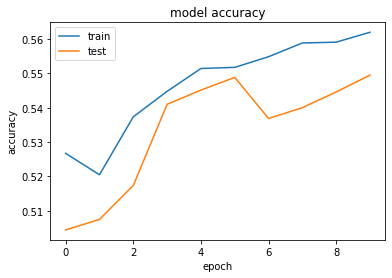

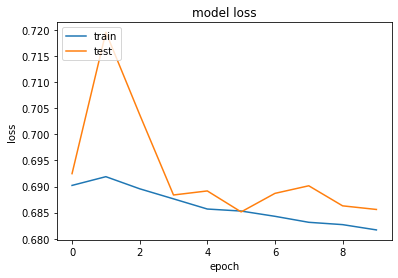

In [35]:
model.save(f"models/{NAME}")
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()